# A statistical Conllu file Exploration of  Universal Dependencies

## Introduction

While much work is being done in the current days on NLP and NLU, there is little work on describing why a certain length of transformer (or other as LSTM time steps) architecture has been chosen for the training, it is mostly arbitrary and depends on the goal of the work and resources available (mainly hardware). These decisions are hard once the model has been trained and there is nothing that can be done to extend the length of a transformer (for example) without having to retrain the entire network. There are however some works that tackle variable length sequences. 

This work presents a first complete analysis of the Universal Dependencies v2.6 dataset and presents the globan and individual results of each language present in the dataset.

This work does not intend to be a conference level paper (that is why there are no references to all the papers on each subject), but an informational technical report that might help to better select the most effective compromise text or token length for your particular NLP application.

The number of analyzed languages is 92, the token length is measured as the named UPOS tag in the dataset, while the character length is just that. There is no analysis on what constitutes a word or not, this means that a token includes the punctuiation and other symbols presents in the text samples. For lingüstic analysis purposes more de




## Observations

The histograms show a skew on the distribution, this can be a skewed gaussian, a generalized gaussian or a beta distribution form.

While doing this work I found quite interesting that are languages whose number of tokens or characters avoid certain bins in the histogram (Bulgarian, Breton Welsh, Danish, Slovak, Tamil and Thai are a few examples of this). This can mean that, either the language structure supports only those lengths, or that the analyzed dataset only contains samples that avoid some sentence lengths.

For some languages the number of samples is too small to make any good assumption from the data.


## Conclusion

This work presents a sample length analysis by language on the UniversalDependencies v2.6 dataset presenting the statistics for all 92 represented languages. The analysis then shows the length histograms by character and token length.

The best compromise for choosing a sequence length on the NLP architecture for training will depend mostly on the requirements of the applicatino, nevertheless with the numbers here you should be able to make an informed guess on what might be better for your case.

We can see that having a multi-lingual approach will necessary make the needed sequences longer as there is a large variability on sequence length, but appliying to single language might allow you to optimize your neural architectures

## Future Work

I am currently working on a more in depth analysis of the complete Gutenberg project dataset ( ~60K books in several languages) that will discriminate several other text characteristics.

I also have started to work on a complete parsing of a few of the Wiktionary datasets.

Stay tuned for those results ;)

In [1]:
from multiprocessing import Pool, cpu_count

import math
import os, sys
import orjson as json
import pyconll
import pyconll.util
from pycountry import languages

try:
    from utf8.utils import *
except:
    # to solve issue with ipython executing this import
    from utils import *

from preprocessors.preprocess_conllu import *

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

%matplotlib inline

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [3]:
# UD_VERSION = "2.6"
# BASEPATH = "/home/leo/projects/Datasets/text"
# CONLLU_BASEPATH = os.path.join(BASEPATH, 'UniversalDependencies/ud-treebanks-v{}'.format(UD_VERSION))
CONLLU_BASEPATH = "/home/leo/projects/Datasets/text/UniversalDependencies/ud-treebanks-v2.6"

In [4]:
rootdir=CONLLU_BASEPATH
blacklist=[]  # BLACKLIST
allconll = get_all_files_recurse(rootdir)
train, test, dev = filter_conllu_files(allconll, blacklist)

In [5]:
def conllu_get_fields(fname):
    """
    Processes one conllu file
    :param fname: absolute path to the conllu file
    :return:
    """
    conll = pyconll.load_from_file(fname)
    upos = []
    xpos = []
    deprel = []
    sentences = []
    forms = []

    src_lang = path_leaf(fname).split('_')[0]
    for sen in conll:
        sentences.append((src_lang, sen.text))
        try:
            forms.extend([t.form for t in sen._tokens])
        except:
            pass
        try:
            sen_upos = [t.upos for t in sen._tokens]
            upos.append((src_lang, sen.text, tuple(sen_upos)))
        except:
            pass
        try:
            sen_xpos = [t.xpos for t in sen._tokens]
            xpos.append((src_lang, sen.text, tuple(sen_xpos)))
        except:
            pass
        try:
            sen_deprel = [t.deprel for t in sen._tokens]
            deprel.append((src_lang, sen.text, tuple(sen_deprel)))
        except:
            pass
    
    return (set(upos), len(upos)), (set(xpos), len(xpos)), (set(deprel), len(deprel)), (set(sentences), len(sentences)), (set(forms), len(forms))


In [6]:
def _try_get_2list(fname):
    try:
        return conllu_get_fields(fname)
    except Exception as e:
        print("Error processing file: {} \nWith error: {}".format(fname, e))


def conllu_process_get_2list(rootdir=CONLLU_BASEPATH, blacklist=BLACKLIST):
    allconll = get_all_files_recurse(rootdir)
    train, test, dev = filter_conllu_files(allconll, blacklist)
    all_files = train + test + dev
#     print(all_files)

    with Pool(processes=cpu_count()) as pool:
        res = pool.map(_try_get_2list, all_files)
        return res


In [7]:
%%time
res = conllu_process_get_2list(blacklist=[])

CPU times: user 12.2 s, sys: 2.79 s, total: 15 s
Wall time: 3min 13s


Finding now the shortest and longest sequences, checking the length and plotting those to see what's happening with the dataset.

In [8]:
%%time

upos_data = []
xpos_data = []
deprel_data = []
sentences_data = []
forms_data = []

for r in res:
    upos_val, xpos_val, deprel_val, sentences_val, forms_val = r
#     print("lala 1")
    forms_data.extend(forms_val[0])
    for val in upos_val[0]:
#         print(val)
        lang1, txt1, upos  = val
        upos_data.append((lang1, txt1, upos, len(upos)))
    for lang2, txt2, xpos in xpos_val[0]:
        xpos_data.append((lang2, txt2, xpos, len(xpos)))
    for lang3, txt3, deprel in deprel_val[0]:
        deprel_data.append((lang3, txt3, deprel, len(deprel)))
    for lang4, txt4 in sentences_val[0]:
        sentences_data.append((lang4, txt4, len(txt4)))

# upos_data = sorted(upos_data)
# xpos_data = sorted(xpos_data)
# deprel_data = sorted(deprel_data)

    

CPU times: user 2.04 s, sys: 154 ms, total: 2.2 s
Wall time: 2.22 s


In [9]:
df_upos = pd.DataFrame(upos_data, columns=["lang", "text", "upos", "upos_len"])
df_xpos = pd.DataFrame(xpos_data, columns=["lang", "text", "xpos", "xpos_len"])
df_deprel = pd.DataFrame(deprel_data, columns=["lang", "text", "deprel", "deprel_len"])
df_txt = pd.DataFrame(sentences_data, columns=["lang", "text", "text_len"])

In [10]:
df_upos.columns

Index(['lang', 'text', 'upos', 'upos_len'], dtype='object')

In [11]:
df_upos['lang'].describe()

count     1288375
unique         92
top            de
freq       204276
Name: lang, dtype: object

In [12]:
langs = sorted(df_upos['lang'].unique())

In [13]:
len(langs)

92

In [27]:
# modified from 
def get_best_distribution(data):
    distributions = {"norm": stats.norm,
                     "skewnorm": stats.skewnorm,
                     "gennorm": stats.gennorm,
                     "beta": stats.beta,
                     }
                  
    dist_results = []
    params = {}
    for dist_name, dist in distributions.items():
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = stats.kstest(data, dist_name, args=param)
#         print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, D, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[2]))
    # store the name of the best fit and its p value

#     print("Best fitting distribution: "+str(best_dist))
#     print("Best p value: "+ str(best_p))
#     print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]

<timed exec>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Error processing lang qhe with Exception 'NoneType' object has no attribute 'name'
CPU times: user 26.6 s, sys: 54.6 ms, total: 26.7 s
Wall time: 26.8 s


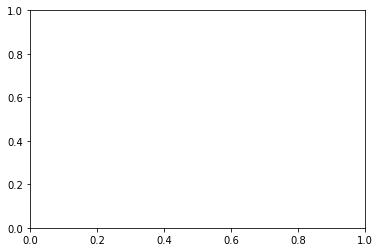

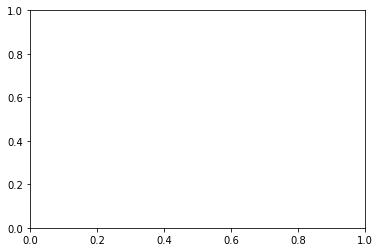

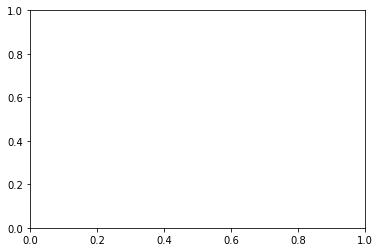

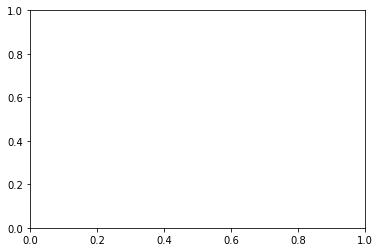

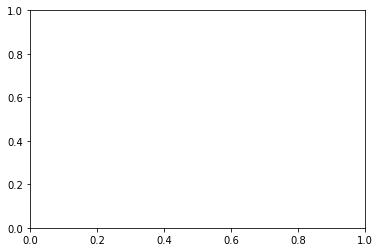

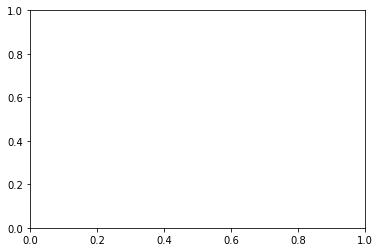

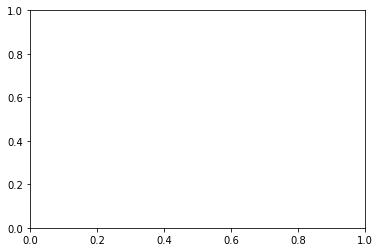

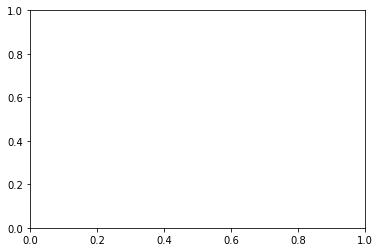

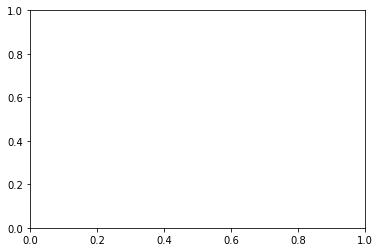

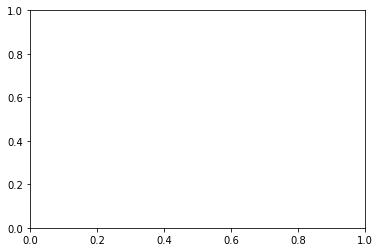

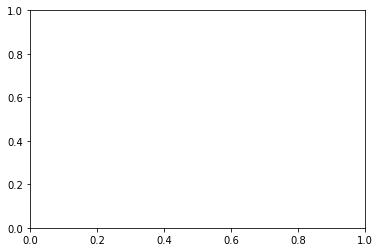

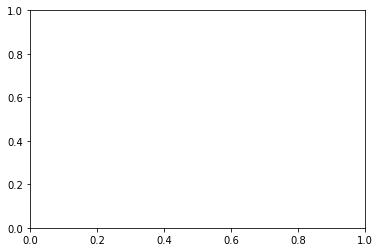

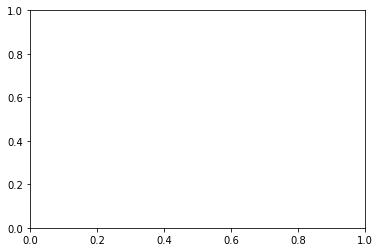

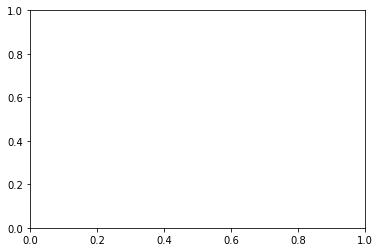

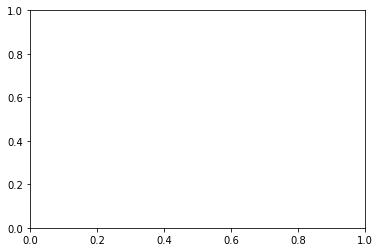

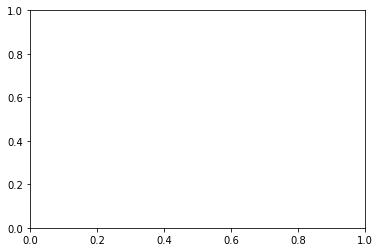

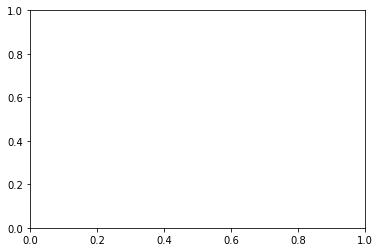

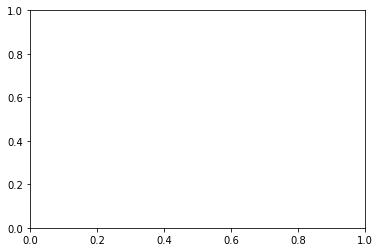

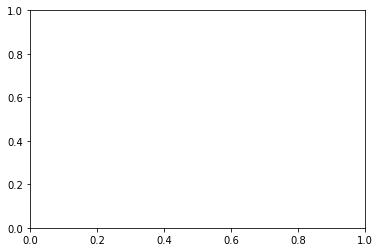

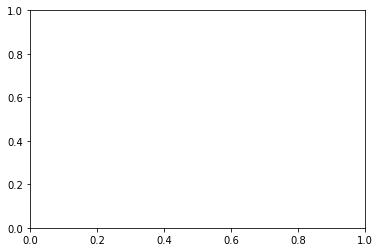

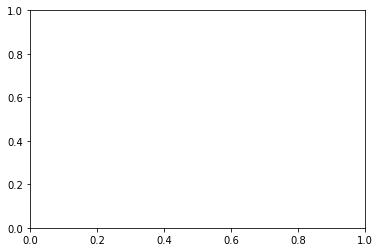

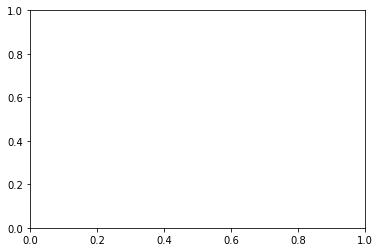

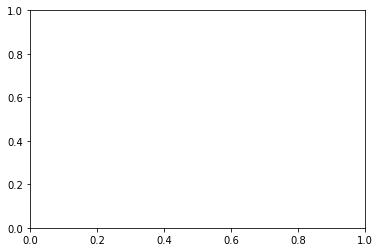

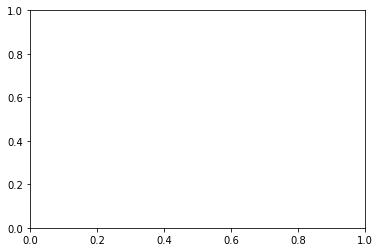

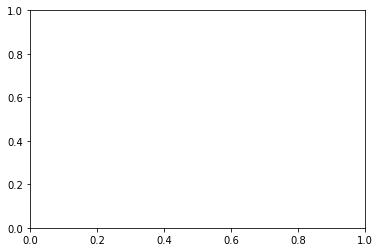

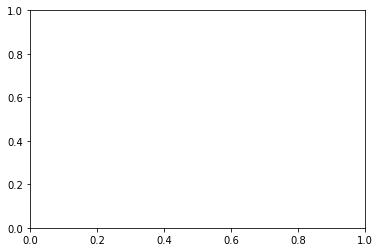

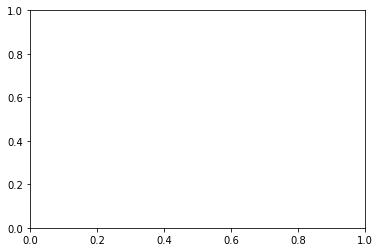

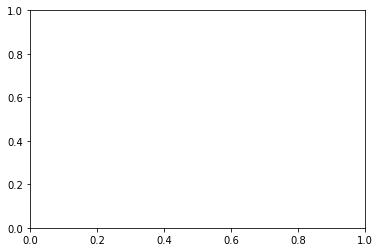

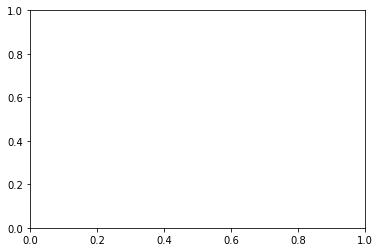

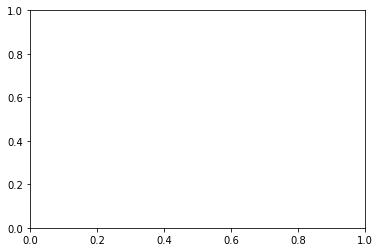

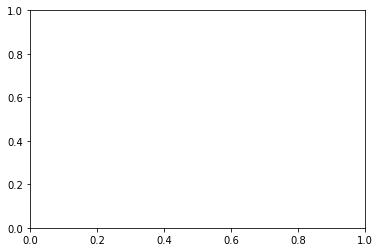

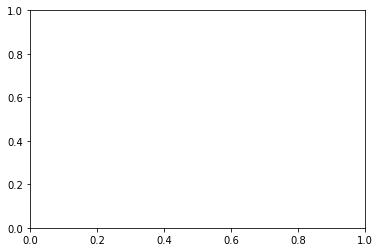

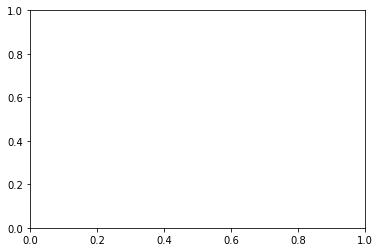

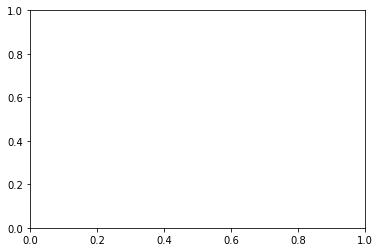

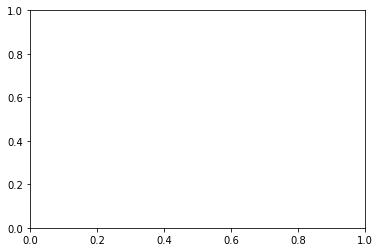

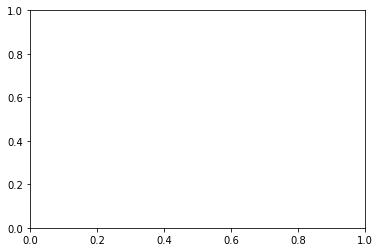

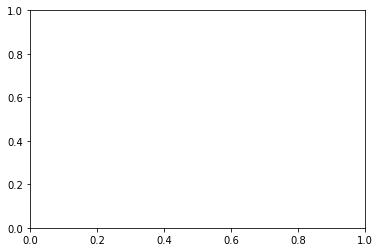

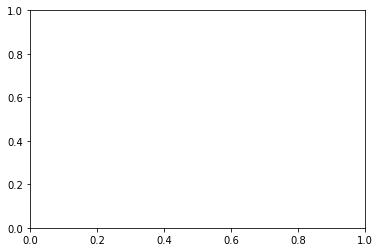

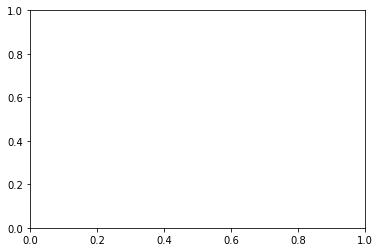

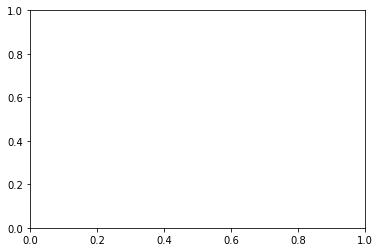

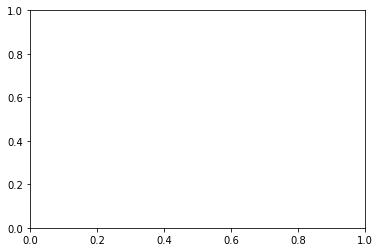

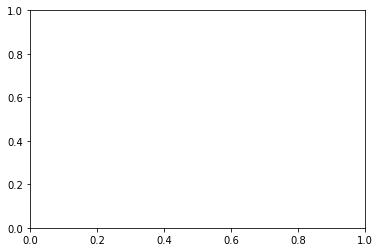

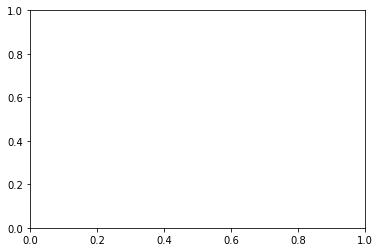

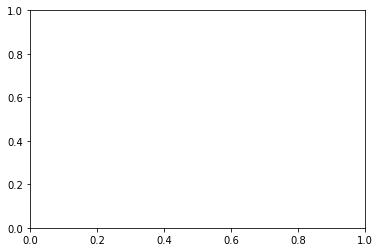

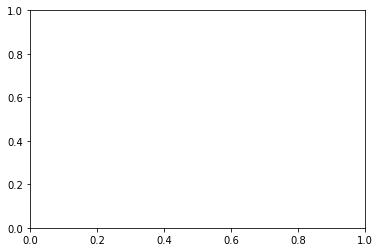

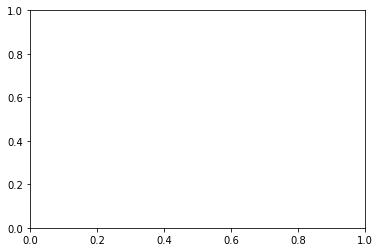

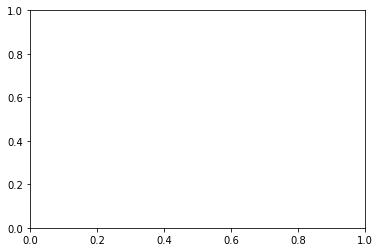

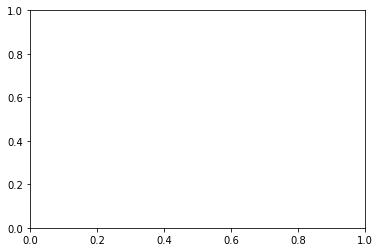

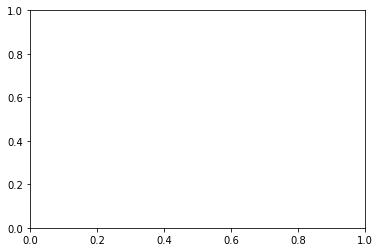

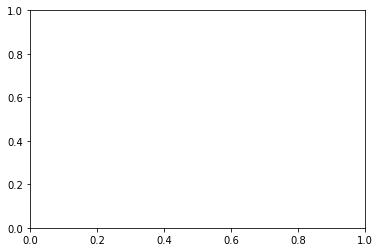

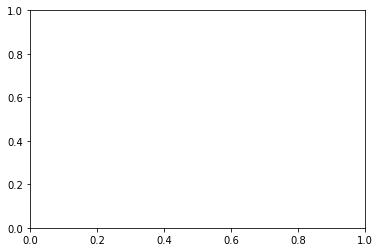

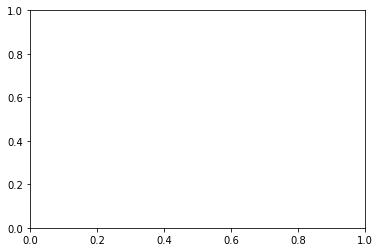

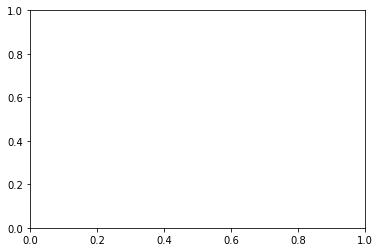

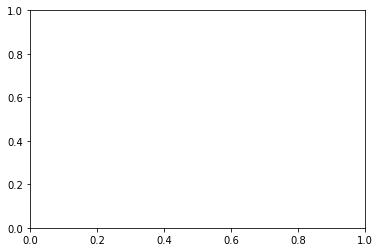

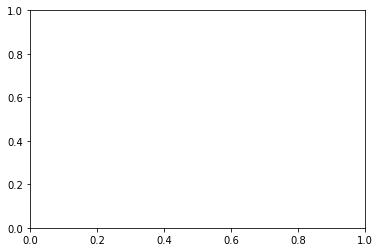

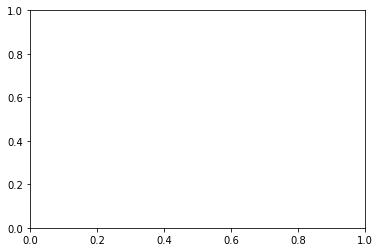

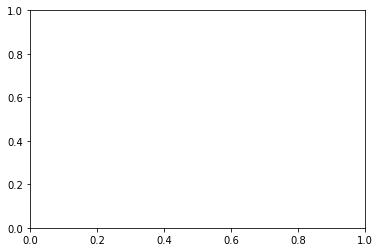

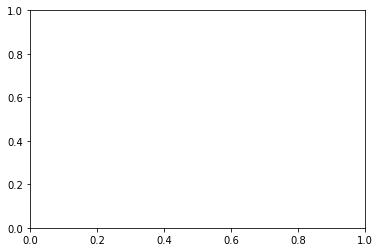

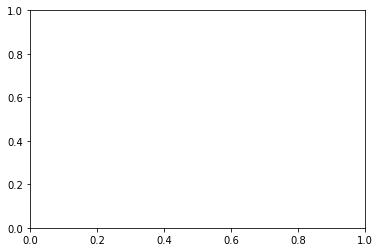

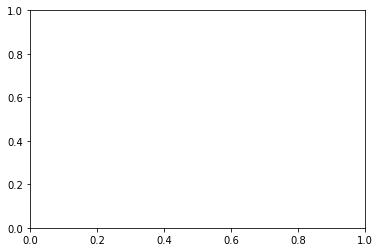

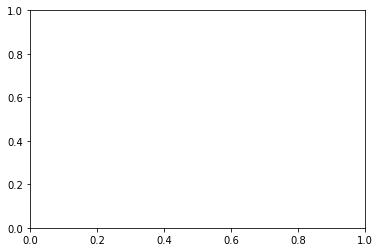

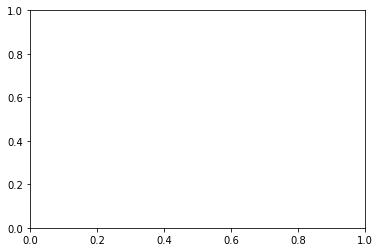

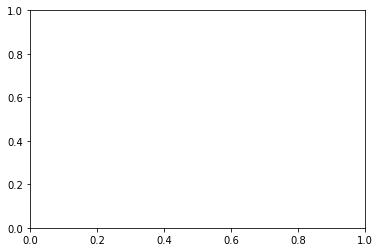

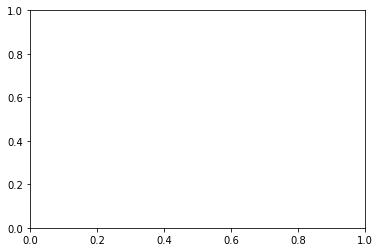

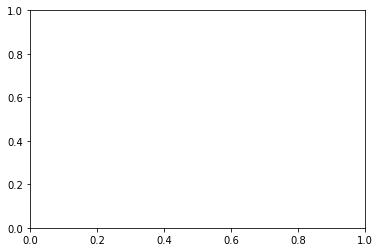

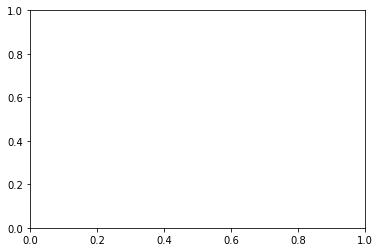

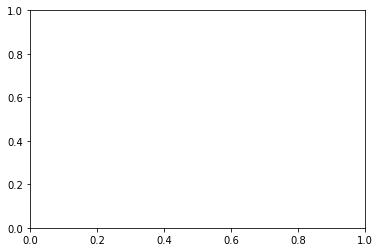

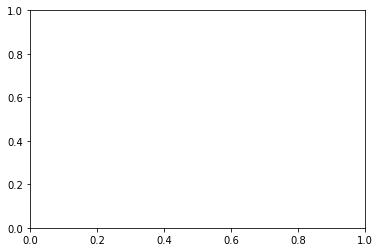

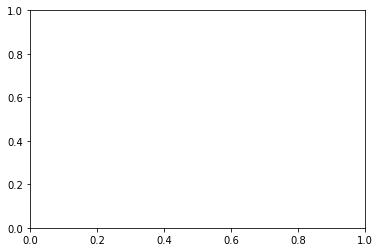

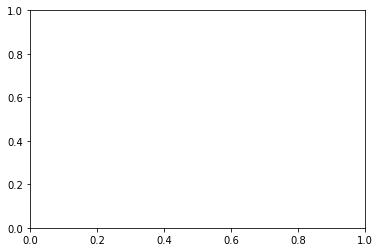

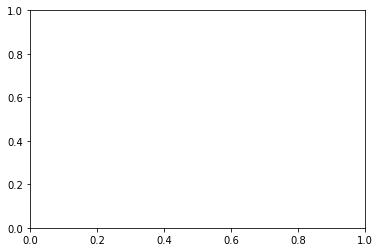

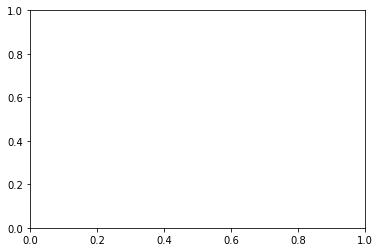

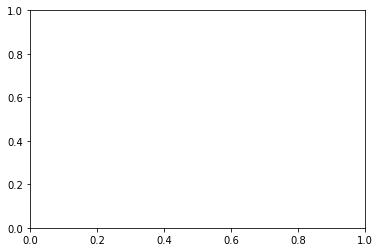

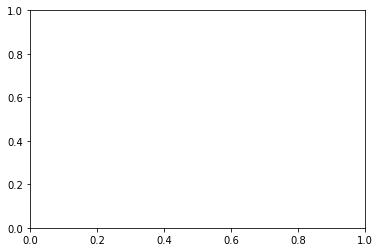

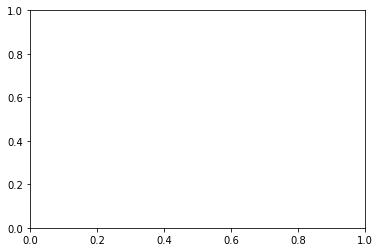

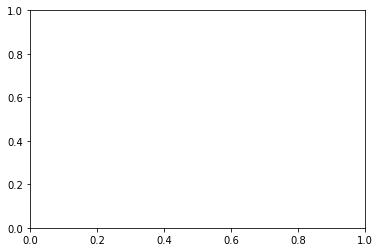

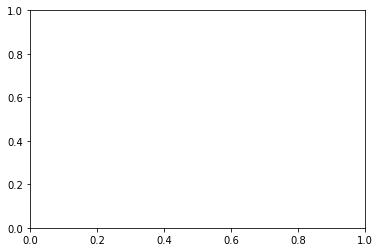

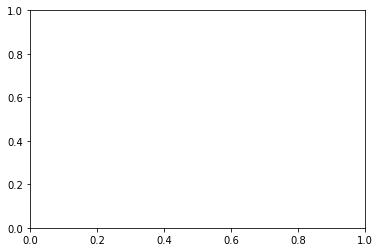

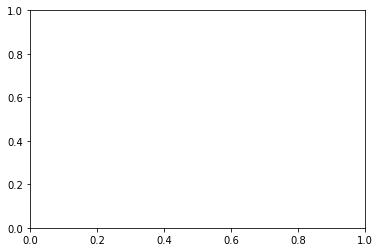

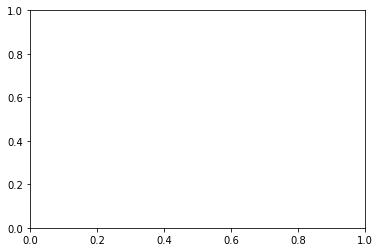

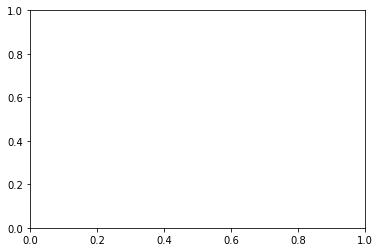

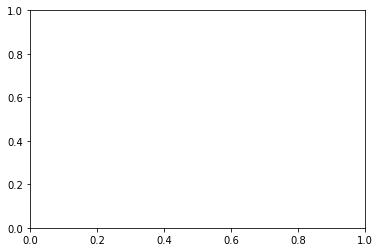

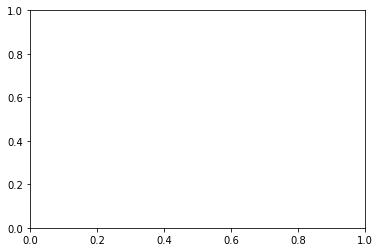

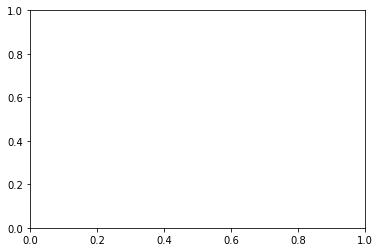

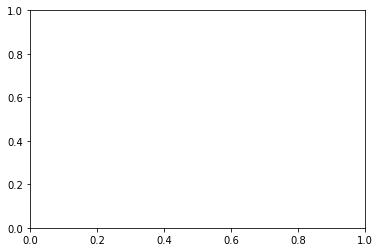

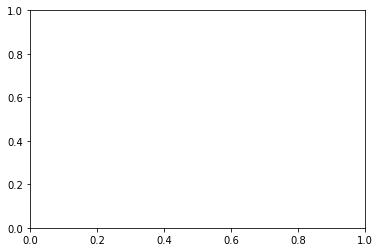

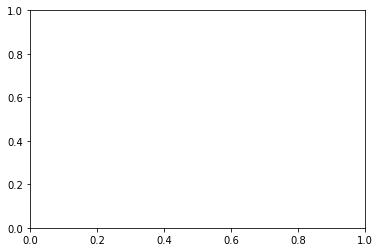

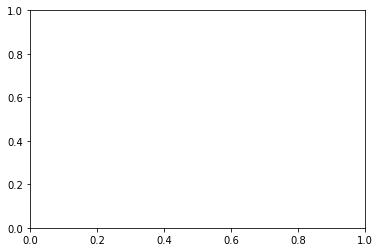

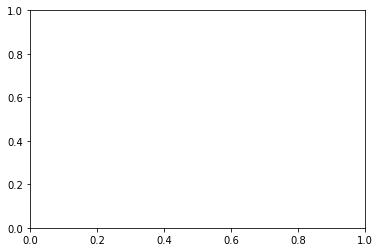

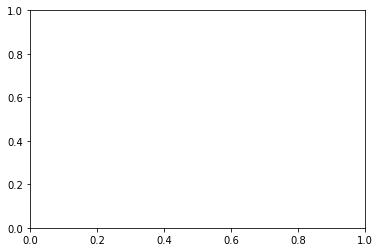

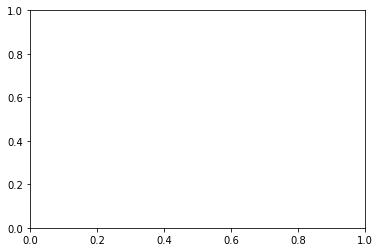

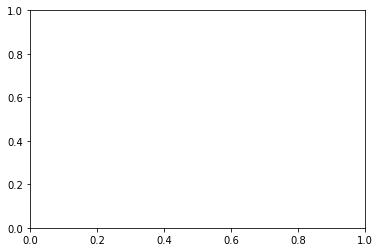

In [14]:
%%time
langs_data = {}


for lang in langs:
    try:
        fig, ax = plt.subplots()
        dest_lang = languages.get(alpha_2=lang) if len(lang) == 2 else languages.get(alpha_3=lang)
        dest_lang = dest_lang.name
        ax.set_title(lang +":" +dest_lang )
        lng_upos_len = df_upos.loc[df_upos['lang'] == lang]['upos_len']  
        lng_deprel_len = df_deprel.loc[df_deprel['lang'] == lang]['deprel_len']
        lng_text_len = df_txt.loc[df_txt['lang'] == lang]['text_len']
        
        langs_data[lang] = {
            'lang': dest_lang,
            'upos_len': lng_upos_len,
            'upos_distrib': get_best_distribution(lng_upos_len),
            'deprel_len': lng_deprel_len,
            'deprel_distrib': get_best_distribution(lng_deprel_len),
            'text_len': lng_text_len,
            'text_distrib': get_best_distribution(lng_text_len),
        }
        
    except Exception as e:
        print("Error processing lang {} with Exception {}".format(lang, e))
        pass

In [17]:
frupos = langs_data['fr']['upos_len']


In [18]:
frupos_norm = stats.norm.fit(frupos)
frupos_beta = stats.beta.fit(frupos)

/home/leo/venv3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/leo/venv3/lib/python3.8/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


frupos_norm

In [19]:
frupos_norm, frupos_beta

((26.55730377257286, 17.290024729527286),
 (2.328372827493223,
  888069.8279996342,
  0.24182457861422196,
  10057137.131721482))

In [24]:
best_distrib = get_best_distribution(frupos)

p value for norm = 0.0


/home/leo/venv3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/leo/venv3/lib/python3.8/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


p value for beta = 1.0539453859211309e-12
p value for expon = 0.0
Best fitting distribution: beta
Best p value: 1.0539453859211309e-12
Parameters for the best fit: (2.328372827493223, 888069.8279996342, 0.24182457861422196, 10057137.131721482)
